<h1> Adjusting the learning rate </h1>

Goal of this notebook is to find an optimal learning rate. The jumpy validation loss suggest a lower learning rate than $\alpha = 0.005$

In [1]:
import myfunctions as mf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
from scipy.optimize import curve_fit
import time
import random

In [2]:
# load data
rootfile = uproot.open("./stage1_clusters_bigdata.root")
event = rootfile["user202302;1"]
xMC = event["x_MC"].array(library="np") #[:40000]
yMC = event["y_MC"].array(library="np") #[:40000]
EMC = event["E_MC"].array(library="np") #[:40000]
x_truth = event["x_truth"].array(library="np") #[:40000]
y_truth = event["y_truth"].array(library="np") #[:40000]
E_truth = event["E_truth"].array(library="np") #[:40000]
x_fit = event["x_fit"].array(library="np") #[:40000]
y_fit = event["y_fit"].array(library="np") #[:40000]
E_fit = event["E_fit"].array(library="np") #[:40000]

In [3]:
clusters5x5, coord, ind_del = mf.form_cluster(xMC, yMC, EMC)
clusters = clusters5x5.reshape((clusters5x5.shape[0], 25))

This took  164.89770579338074 s


In [4]:
# cut data and from trainings and test data
xMC_train, xMC_veri, yMC_train, yMC_veri, EMC_train, EMC_veri, x_truth_train, x_truth_veri, y_truth_train, y_truth_veri, E_truth_train, E_truth_veri, x_fit_veri, y_fit_veri, E_fit_veri, clusters_t, clusters_v, coord_t, coord_v = mf.training_and_validation_data(xMC, yMC, EMC, x_truth, y_truth, E_truth, x_fit, y_fit, E_fit, ind_del, clusters, coord)

In [5]:
# prep data
training = mf.prep_trainingsdata(x_truth_train, y_truth_train, E_truth_train, coord_t)
veri_truth_data = mf.prep_trainingsdata(x_truth_veri, y_truth_veri, E_truth_veri, coord_v)
veri_fit_data = mf.prep_trainingsdata(x_fit_veri, y_fit_veri, E_fit_veri, coord_v)

<h2> Learning rate $\alpha = 0.001$ </h2>

$\alpha = 0.01$ is the default value, so I reduce it by one order of magnitude.

In [7]:
model1 = keras.Sequential([layers.Input(shape=(25)),
                         layers.LayerNormalization(axis=1),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(3, activation=None)])
model1.summary()
model1.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization_1 (Layer (None, 25)                50        
_________________________________________________________________
dense_7 (Dense)              (None, 64)                1664      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)               

In [8]:
a = time.time()
fit_hist = model1.fit(clusters_t, training, batch_size=50, epochs=50, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/50
10353/10353 [==============================] - 21s 2ms/step - loss: 14.3791 - val_loss: 0.0544
Epoch 2/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.1753 - val_loss: 0.0399
Epoch 3/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.1324 - val_loss: 0.0396
Epoch 4/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.1157 - val_loss: 0.0791
Epoch 5/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.1033 - val_loss: 0.0419
Epoch 6/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0922 - val_loss: 0.3610
Epoch 7/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0849 - val_loss: 0.0170
Epoch 8/50
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0777 - val_loss: 0.0306
Epoch 9/50
10353/10353 [==============================] - 21s 2ms/step - loss: 0.0756 - val_loss: 0.0668
Epoch 10/50
10353/10353 [=============================

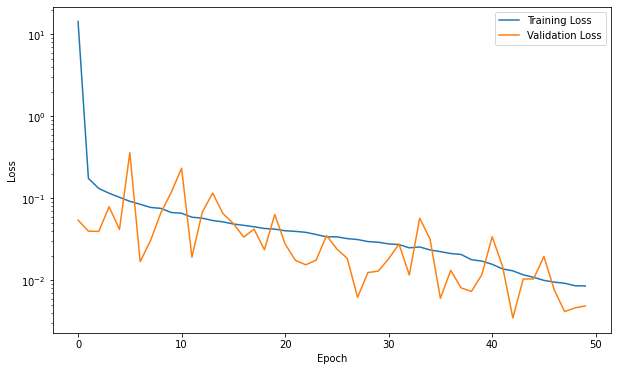

In [9]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist)

In [10]:
output = model1.predict(clusters_v)

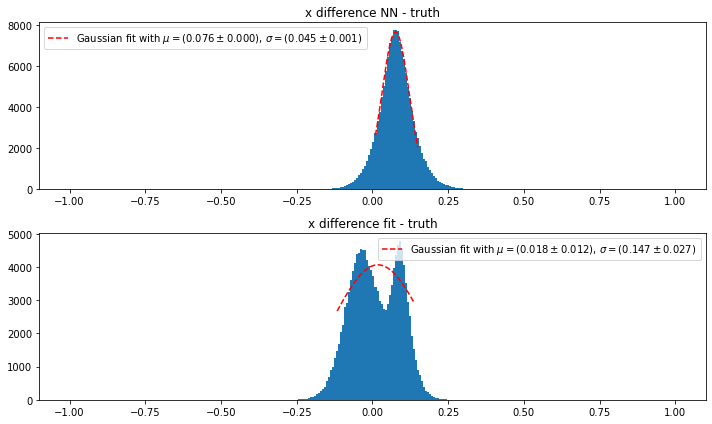

(array([7.62093369e-02, 4.53204376e-02, 8.69157181e+02]),
 array([4.34492386e-04, 5.72794982e-04, 8.84351282e+00]),
 array([1.81492250e-02, 1.47273909e-01, 1.50082021e+03]),
 array([1.16207871e-02, 2.74487217e-02, 2.33705332e+02]))

In [11]:
mf.histo_output(output.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x")

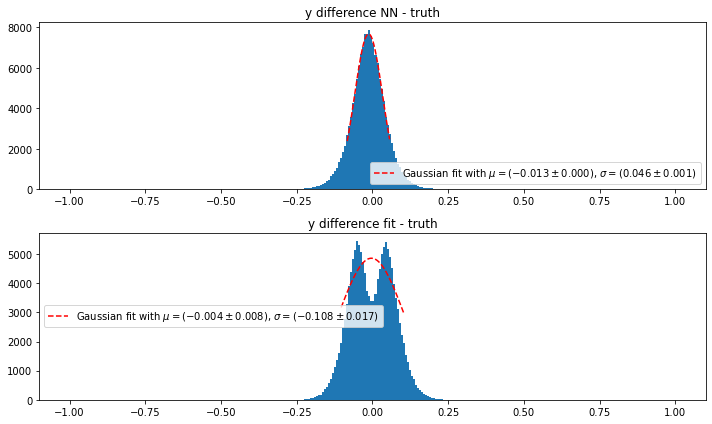

(array([-1.27721985e-02,  4.60984746e-02,  8.86225916e+02]),
 array([3.91281868e-04, 5.20862278e-04, 8.04546813e+00]),
 array([-3.59335380e-03, -1.07901939e-01,  1.31559350e+03]),
 array([7.84167892e-03, 1.66460001e-02, 1.64990425e+02]))

In [12]:
mf.histo_output(output.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

In [14]:
#keras.models.save_model(model1, 'stage1model_lr0.001')

INFO:tensorflow:Assets written to: stage1model_lr0.001/assets


This seems like I didn't use enough epochs as there is still a gradient visible. Let's try it with 200 epochs.

In [15]:
a = time.time()
fit_hist_longer = model1.fit(clusters_t, training, batch_size=50, epochs=150, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/150
10353/10353 [==============================] - 21s 2ms/step - loss: 0.0082 - val_loss: 0.0043
Epoch 2/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0079 - val_loss: 0.0196
Epoch 3/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0078 - val_loss: 0.0095
Epoch 4/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0077 - val_loss: 0.0033
Epoch 5/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 6/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0073 - val_loss: 0.0035
Epoch 7/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0072 - val_loss: 0.0165
Epoch 8/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0073 - val_loss: 0.0047
Epoch 9/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 10/150
10353/10353 [====================

10353/10353 [==============================] - 20s 2ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 78/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 79/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 80/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 81/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 82/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 83/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 84/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 85/150
10353/10353 [==============================] - 20s 2ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 86/150
10353/10353 [========================

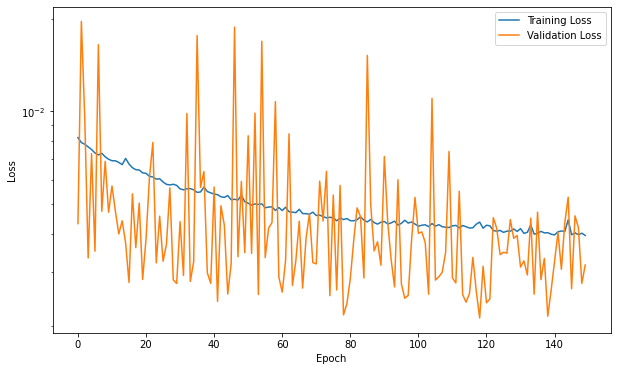

In [16]:
mf.training_vs_validation_loss(fit_hist_longer)

Look at it all together...


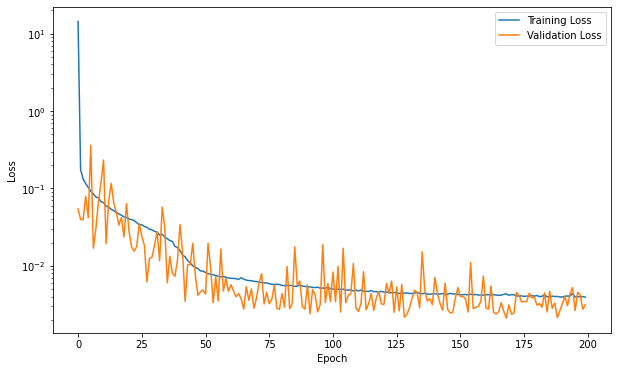

In [17]:
loss = np.concatenate((fit_hist.history['loss'], fit_hist_longer.history['loss']))
val_loss = np.concatenate((fit_hist.history['val_loss'], fit_hist_longer.history['val_loss']))
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training Loss", "Validation Loss"])
plt.yscale('log')
plt.show()

In [18]:
#keras.models.save_model(model1, 'stage1model_lr0.001_200epochs')

INFO:tensorflow:Assets written to: stage1model_lr0.001_200epochs/assets


In [19]:
output_l = model1.predict(clusters_v)

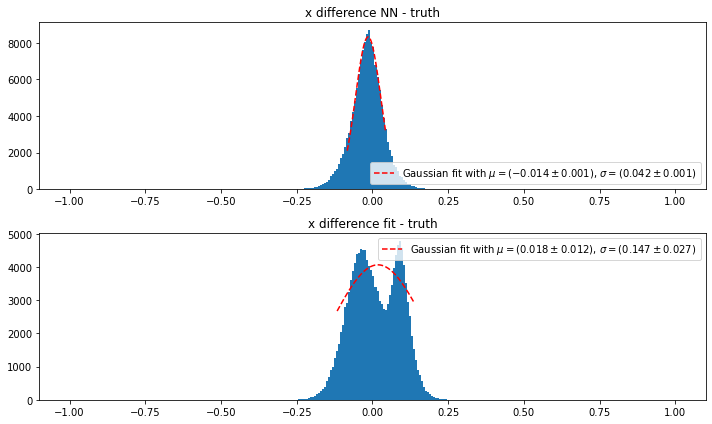

(array([-1.44060247e-02,  4.15761279e-02,  8.68152181e+02]),
 array([6.12205911e-04, 8.06527403e-04, 1.35767595e+01]),
 array([1.81492250e-02, 1.47273909e-01, 1.50082021e+03]),
 array([1.16207871e-02, 2.74487217e-02, 2.33705332e+02]))

In [21]:
mf.histo_output(output_l.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x")

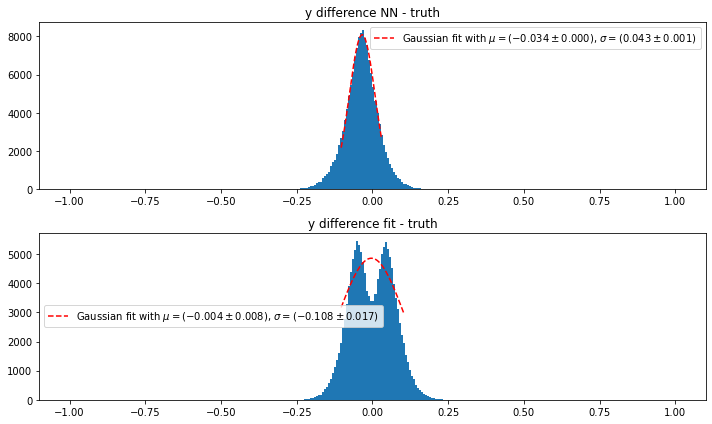

(array([-3.40216173e-02,  4.27861239e-02,  8.67221971e+02]),
 array([4.81904993e-04, 6.29188174e-04, 1.02871876e+01]),
 array([-3.59335380e-03, -1.07901939e-01,  1.31559350e+03]),
 array([7.84167892e-03, 1.66460001e-02, 1.64990425e+02]))

In [22]:
mf.histo_output(output_l.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

<h2> summary </h2>

| (x/y) | $\mu$ | $\sigma$ |
| --- | --- | --- |
| simplest model $\alpha=0.005$ |0.035 / 0.040 | 0.054 / 0.044 |
| simplest model & standardization $\alpha=0.005$ | 0.047 / 0.048  | 0.044 / 0.045 |
| simplest model & standardization & $\alpha=0.001$, 50 epochs| 0.076 / 0.013  | 0.045 / 0.046 |
| simplest model & standardization & $\alpha=0.001$, 200 epochs| 0.014 / 0.034  | 0.042 / 0.043 |

This doesn't seem to improve too much...